## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [12]:
!pip install contractions
!pip install nltk
!pip install matplotlib
!pip install sklearn
#!pip install pyspellchecker 
!pip install collections
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics import confusion_matrix
import contractions
import re
import string
#from spellchecker import SpellChecker
from nltk import word_tokenize
nltk.download('punkt')
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load dataset

In [13]:
df=pd.read_csv('emails.txt',sep="\t",header=None,names=['class','email'])
df.head()

,class,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Preprocess data

In [14]:
df.drop_duplicates(inplace=True)
df['email']=df['email'].str.lower()
df['email']=df['email'].apply(lambda x:contractions.fix(x))
#df['email']=df['email'].apply(lambda x : re.sub)
#df['email']=df['email'].apply(lambda x:re.sub('b[w\-.]+?@w+?.w{2,4}b', 'emailaddress',x))
#df['email']=df['email'].apply(lambda x:re.sub('(http[s]?S+)|(w+.[A-Za-z]{2,4}S*)','', x))
#df['email'][12]

df['email']=df['email'].apply(lambda x:re.sub('\S+@\S+','emailaddress',x))
#df['email'][136]


df['email']=df['email'].apply(lambda x:re.sub('https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}','url',x))
#df['email'][12]
df['email']=df['email'].apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '' , x))
#df['email'][12]
df['email']=df['email'].apply(lambda x: re.sub('\W*\d\w*','',x))
#df['email'][12]
#spell=SpellChecker()
#df['email']=df['email'].apply(lambda x:" ".join([spell.correction(word) for word in x.split()]))


stop_words=set(stopwords.words('english'))
df['email']=df['email'].apply(lambda x:" ".join([word for word in x.split() if word not in stop_words]))
#df['email'][12]

lemmatizer = WordNetLemmatizer()
df['email']=df['email'].apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split()]))
#df['email'][39]
df['email']=df['email'].apply(lambda x: re.sub(' +', ' ', x))
df['email']=df['email'].apply(lambda x:word_tokenize(x))

df['email'][2]
df.head()
#def spell_checker(text):



,class,email
0,ham,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,"[ok, lar, joking, wif, oni]"
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,"[dun, say, early, hor, c, already, say]"
4,ham,"[nah, think, go, usf, life, around, though]"


#TF-IDF#

In [15]:
df=df.reset_index(drop=True)
rowcount=df.shape[0]
DOC_FREQ={}
for i in range(rowcount):
  tokens=df['email'][i]
  for w in tokens:
    try:
      DOC_FREQ[w].add(i)
    except:
      DOC_FREQ[w]={i}

for i in DOC_FREQ:
  DOC_FREQ[i]=len(DOC_FREQ[i])



corpus_vocab=[x for x in DOC_FREQ]

vocab_size=len(corpus_vocab)

TF_IDF={}
for i in range(rowcount):
  num_words=len(df['email'][i])
  tokens=df['email'][i]
  counter=Counter(tokens)
  for token in np.unique(tokens):
    tf=counter[token]/num_words
    doc_frequency=DOC_FREQ[token]
    idf=np.log(rowcount/(doc_frequency+1))
    TF_IDF[i,token]=tf*idf




DOC_VEC=np.zeros((rowcount,vocab_size))
for i in TF_IDF:
  ind=corpus_vocab.index(i[1])
  DOC_VEC[i[0]][ind]=TF_IDF[i]


df_vector=df



  




### Split data

In [16]:
num_rows=int(len(DOC_VEC)*0.8)
train=DOC_VEC[:num_rows]
test=DOC_VEC[num_rows:]
print(len(train))
print(len(test))

4135
1034


### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data
1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] to handle categorical attributes and compare with the Cosine Similarity distance results. 
2. Explain which distance measure works best and why?
3. Report Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score in a tabular form
4. Choose different K values (k=2,3,5,7,11,16) and experiment. Plot a graph showing R2 score vs k.

In [17]:
def cosine_similarity(list1,list2):
  return np.dot(list1,list2)/(norm(list1)*norm(list2))
'''
def euclidean_distance(list1,list2):
  a=np.array(list1)
  b=np.array(list2)
  return np.linalg.norm(a-b)

def manhattan_distance(list1,list2):
  a=np.array(list1)
  b=np.array(list2)
  return np.abs(a - b).sum()
'''  
'''
def hamming_distance(list1,list2):
  
  dist=0
  for i in range(len(list1)):
    if list1[i]!=list2[i]:
      dist+=1
  return dist
  
  a=np.array(list1)
  b=np.array(list2)
  return np.count_nonzero(a!=b)
  '''


test_labels=[]
def KNN(k,train,test):
  for i in range(len(test)):
    top5=[]
    for j in range(len(train)):
      dist=cosine_similarity(train[j],test[i])
      top5.append((j,dist))
      if len(top5)>k:
        top5.sort(key=lambda u:u[1],reverse=True)
        del top5[-1]
    
    spam_count=0
    ham_count=0
    for tuples in top5:
      index=tuples[0]
      if df['class'][index]=='spam':
        spam_count=spam_count+1
      else:
        ham_count=ham_count+1

    if ham_count>spam_count:
      #test_labels.append((len(train)+i,0))
      test_labels.append(0)
    else:
      #test_labels.append((len(train)+i,1))
      test_labels.append(1)

def knn_others(k,train,test):
    for i in range(len(test)):
      top5=[]
      for j in range(len(train)):
        dist=hamming_distance(train[j],test[i])
        top5.append((j,dist))
        if len(top5)>k:
          top5.sort(key=lambda u:u[1])
          del top5[-1]
    
      spam_count=0
      ham_count=0
      for tuples in top5:
        index=tuples[0]
        if df['class'][index]=='spam':
          spam_count=spam_count+1
        else:
          ham_count=ham_count+1

      if spam_count>ham_count:
        #test_labels.append((len(train)+i,1))
        test_labels.append(1)
      else:
        #test_labels.append((len(train)+i,0))
        test_labels.append(0)


k=5
KNN(k,train,test)
#knn_others(k,train,test)
'''
print(len(test_labels))
correct_pred=0
for i in range(len(train),len(train)+len(test)):
  if df['class'][i]=='spam' and test_labels[i-len(train)]==1:
    correct_pred+=1
  if df['class'][i]=='ham' and test_labels[i-len(train)]==0:
    correct_pred+=1
accuracy=(correct_pred/len(test))
print("Accuracy = ",accuracy)
'''

















/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


'\nprint(len(test_labels))\ncorrect_pred=0\nfor i in range(len(train),len(train)+len(test)):\n  if df[\'class\'][i]==\'spam\' and test_labels[i-len(train)]==1:\n    correct_pred+=1\n  if df[\'class\'][i]==\'ham\' and test_labels[i-len(train)]==0:\n    correct_pred+=1\naccuracy=(correct_pred/len(test))\nprint("Accuracy = ",accuracy)\n'

In [18]:
df_new=df['class'][len(train):]
df_new.shape
df_new.head()
print("Using Cosine similarity and k=5")
print()
for i in range(len(train),len(test)+len(train)):
  if df_new[i]=='spam':
    df_new[i]=1
  if df_new[i]=='ham':
    df_new[i]=0

actual_values=df_new.tolist()
print("Confusion Matrix")
print(confusion_matrix(actual_values,test_labels))
print()
print("Classification report")
print(classification_report(actual_values, test_labels))
print()
print("0->ham")
print("1->spam")
print()
'''
tn, fp, fn, tp = confusion_matrix(actual_values, test_labels).ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print(precision)
print(recall)
f1_score=2*precision*recall/(precision+recall)
print(f1_score)
'''












Using Cosine similarity and k=5

Confusion Matrix
[[910   7]
 [ 26  91]]

Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       917
           1       0.93      0.78      0.85       117

    accuracy                           0.97      1034
   macro avg       0.95      0.89      0.91      1034
weighted avg       0.97      0.97      0.97      1034


0->ham
1->spam



'\ntn, fp, fn, tp = confusion_matrix(actual_values, test_labels).ravel()\nprecision=tp/(tp+fp)\nrecall=tp/(tp+fn)\nprint(precision)\nprint(recall)\nf1_score=2*precision*recall/(precision+recall)\nprint(f1_score)\n'

#KNN using Euclidean#

In [19]:
print("Using Euclidean distance and k=5")
print()
test_labels=[]

def euclidean_distance(list1,list2):
  a=np.array(list1)
  b=np.array(list2)
  return np.linalg.norm(a-b)

def knn_euclidean(k,train,test):
    for i in range(len(test)):
      top5=[]
      for j in range(len(train)):
        dist=euclidean_distance(train[j],test[i])
        top5.append((j,dist))
        if len(top5)>k:
          top5.sort(key=lambda u:u[1])
          del top5[-1]
    
      spam_count=0
      ham_count=0
      for tuples in top5:
        index=tuples[0]
        if df['class'][index]=='spam':
          spam_count=spam_count+1
        else:
          ham_count=ham_count+1

      if spam_count>ham_count:
        #test_labels.append((len(train)+i,1))
        test_labels.append(1)
      else:
        #test_labels.append((len(train)+i,0))
        test_labels.append(0)

k=5
knn_euclidean(k,train,test)

df_new=df['class'][len(train):]
df_new.shape
df_new.head()

for i in range(len(train),len(test)+len(train)):
  if df_new[i]=='spam':
    df_new[i]=1
  if df_new[i]=='ham':
    df_new[i]=0

actual_values=df_new.tolist()
print("Confusion Matrix")
print(confusion_matrix(actual_values,test_labels))
print()
print("Classification report")
print(classification_report(actual_values, test_labels))
print()
print("0->ham")
print("1->spam")
print()








Using Euclidean distance and k=5

Confusion Matrix
[[910   7]
 [ 79  38]]

Classification report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       917
           1       0.84      0.32      0.47       117

    accuracy                           0.92      1034
   macro avg       0.88      0.66      0.71      1034
weighted avg       0.91      0.92      0.90      1034


0->ham
1->spam



#KNN using Manhattan#

In [20]:
def manhattan_distance(list1,list2):
  a=np.array(list1)
  b=np.array(list2)
  return np.abs(a - b).sum()

print("Using Manhattan distance and k=5")
print()
test_labels=[]
def knn_manhattan(k,train,test):
    for i in range(len(test)):
      top5=[]
      for j in range(len(train)):
        dist=manhattan_distance(train[j],test[i])
        top5.append((j,dist))
        if len(top5)>k:
          top5.sort(key=lambda u:u[1])
          del top5[-1]
    
      spam_count=0
      ham_count=0
      for tuples in top5:
        index=tuples[0]
        if df['class'][index]=='spam':
          spam_count=spam_count+1
        else:
          ham_count=ham_count+1

      if spam_count>ham_count:
        #test_labels.append((len(train)+i,1))
        test_labels.append(1)
      else:
        #test_labels.append((len(train)+i,0))
        test_labels.append(0)

k=5
knn_manhattan(k,train,test)

df_new=df['class'][len(train):]
df_new.shape
df_new.head()

for i in range(len(train),len(test)+len(train)):
  if df_new[i]=='spam':
    df_new[i]=1
  if df_new[i]=='ham':
    df_new[i]=0

actual_values=df_new.tolist()
print("Confusion Matrix")
print(confusion_matrix(actual_values,test_labels))
print()
print("Classification report")
print(classification_report(actual_values, test_labels))
print()
print("0->ham")
print("1->spam")
print()





Using Manhattan distance and k=5

Confusion Matrix
[[917   0]
 [ 82  35]]

Classification report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       917
           1       1.00      0.30      0.46       117

    accuracy                           0.92      1034
   macro avg       0.96      0.65      0.71      1034
weighted avg       0.93      0.92      0.90      1034


0->ham
1->spam



#Comparison of distance metrics#

*As we can see from the results of KNN with three distance metrics(cosine,euclidean and manhattan), recall and f1-score values seem to be very poor for euclidean and manhattan distances and cosine similarity seems to work very well on all parameters.* 
<br>

*Cosine similarity works better because it measures the similarity in cosine space(angle between vectors).Few times the test email vector query length can be small but it might be closely related to an email. Cosine similarity helps in those cases.*

<br>

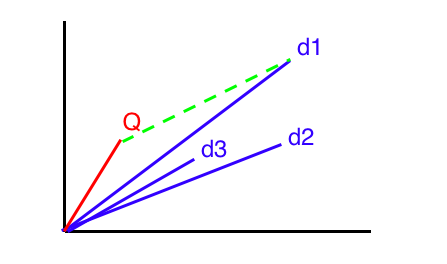

<br>
*In the above diagram, the blue vectors are emails and the red vector is the test email, as we can clearly see, though the manhattan distance (green line) is very high for email d1, the test email vector is still close to email d1. In such cases, cosine similarity would be better as it considers the angle between those two vectors.*




#f1-score vs k graph#

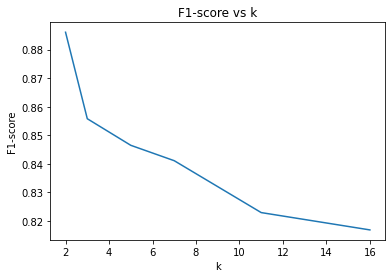

In [21]:
xvalues=[2,3,5,7,11,16]
yvalues=[0.886075949367088,0.855813953488372,0.846511627906976,0.841121495327102,0.822966507177033,0.816901408450704]
plt.plot(xvalues,yvalues)
plt.xlabel("k")
plt.ylabel("F1-score")
plt.title("F1-score vs k")
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [22]:
df_train=df['class'][:len(train)]


for i in range(0,len(train)):
  if df_train[i]=='spam':
    df_train[i]=1
  if df_train[i]=='ham':
    df_train[i]=0
train_labels=df_train.tolist()

classifier=KNeighborsClassifier(n_neighbors=5,metric='cosine')
classifier.fit(train,train_labels)
y_pred=classifier.predict(test)
print("Using sklearn kneighbors classifier")
print()
print("Confusion Matrix")
print(confusion_matrix(actual_values, y_pred))
print()
print("Classification report")
print(classification_report(actual_values, y_pred))
print()
print("0->ham")
print("1->spam")
'''
sktn, skfp, skfn, sktp = confusion_matrix(actual_values, y_pred).ravel()
skprecision=sktp/(sktp+skfp)
skrecall=sktp/(sktp+skfn)
print(skprecision)
print(skrecall)
skf1_score=2*skprecision*skrecall/(skprecision+skrecall)
print(skf1_score)
'''


Using sklearn kneighbors classifier

Confusion Matrix
[[910   7]
 [ 26  91]]

Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       917
           1       0.93      0.78      0.85       117

    accuracy                           0.97      1034
   macro avg       0.95      0.89      0.91      1034
weighted avg       0.97      0.97      0.97      1034


0->ham
1->spam


'\nsktn, skfp, skfn, sktp = confusion_matrix(actual_values, y_pred).ravel()\nskprecision=sktp/(sktp+skfp)\nskrecall=sktp/(sktp+skfn)\nprint(skprecision)\nprint(skrecall)\nskf1_score=2*skprecision*skrecall/(skprecision+skrecall)\nprint(skf1_score)\n'

### Compare both the models result.

*As we can see, with cosine similarity metric, our knn implementation and sklearn's kneighbors give similar results - accuracy,precision,recall and f1-score which is expected.*

**BONUS** : What is the time complexity of training using KNN classifier? What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?

**Answer ->** Time complexity of training using KNN classifier is O(1) <br>
              Time complexity while testing is O(n*d) where n = no of samples and d = no of dimensions in data. <br>
            KNN is not a linear classifier and it can learn any boundary depending upon the k nearest neighbors.